In [5]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def load_data(dataset_path):
    images = []
    labels = []
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        label = 1 if 'fire' in folder.lower() else 0  # 1 for fire, 0 for non-fire
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            img = cv2.imread(image_path)
            
            # Check if the image was loaded successfully
            if img is None:
                print(f"Warning: Could not load image {image_path}")
                continue  # Skip this image if not loaded
            
            # Resize the image
            try:
                img = cv2.resize(img, (64, 64))  
            except cv2.error as e:
                print(f"Error resizing image {image_path}: {e}")
                continue  # Skip this image if resizing fails
            
            images.append(img)
            labels.append(label)
    
    return np.array(images), np.array(labels)

# Use the function to load the dataset
images, labels = load_data('D:/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET')

# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Normalize pixel values
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encoding of labels
y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)
y_test = to_categorical(y_test, 2)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)
datagen.fit(X_train)


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
def create_model():
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))

    return model

# Create and compile the model
model = create_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=10)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc* 100:.2f}')


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 351,618 (1.34 MB)

 Trainable params: 351,618 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
648/648 ━━━━━━━━━━━━━━━━━━━━ 48s 71ms/step - accuracy: 0.8811 - loss: 0.2661 - val_accuracy: 0.9518 - val_loss: 0.1353
Epoch 2/10
648/648 ━━━━━━━━━━━━━━━━━━━━ 48s 73ms/step - accuracy: 0.9470 - loss: 0.1439 - val_accuracy: 0.9556 - val_loss: 0.1299
Epoch 3/10
648/648 ━━━━━━━━━━━━━━━━━━━━ 48s 74ms/step - accuracy: 0.9517 - loss: 0.1290 - val_accuracy: 0.9624 - val_loss: 0.1257
Epoch 4/10
648/648 ━━━━━━━━━━━━━━━━━━━━ 48s 74ms/step - accuracy: 0.9626 - loss: 0.1022 - val_accuracy: 0.9688 - val_loss: 0.1033
Epoch 5/10
648/648 ━━━━━━━━━━━━━━━━━━━━ 48s 74ms/step - accuracy: 0.9656 - loss: 0.0991 - val_accuracy: 0.9666 - val_loss: 0.0986
Epoch 6/10
648/648 ━━━━━━━━━━━━━━━━━━━━ 49s 75ms/step - accuracy: 0.9676 - loss: 0.0952 - val_accuracy: 0.9695 - val_loss: 0.1010
Epoch 7/10
648/648 ━━━━━━━━━━━━━━━━━━━━ 50s 77ms/step - accuracy: 0.9710 - loss: 0.0867 - val_accuracy: 0.9684 - val_loss: 0.1042
Epoch 8/10
648/648 ━━━━━━━━━━━━━━━━━━━━ 49s 75ms/step - accuracy: 0.9681 - loss: 0.0906 - 

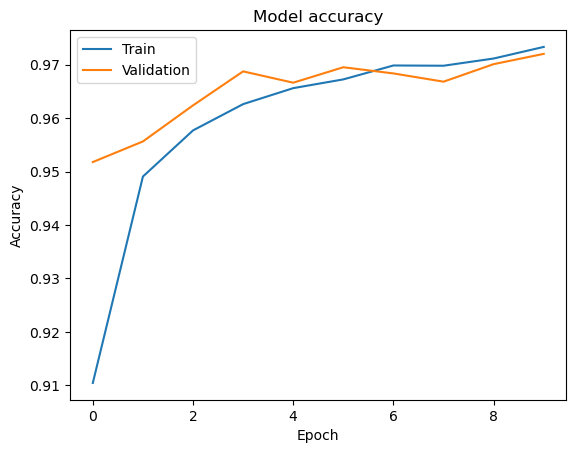

In [9]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [11]:
import keras_tuner as kt
from tensorflow.keras import layers, models

def model_builder(hp):
    model = models.Sequential()
    
    # Input layer
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))  # Assuming 64x64x3 image size
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Additional Conv layers
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Flatten before passing to Dense layers
    model.add(layers.Flatten())
    
    # Hyperparameter tuning for Dense layer units
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(layers.Dense(hp_units, activation='relu'))
    
    # Output layer (binary classification: fire vs non-fire)
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [14]:
model.save('fire_detection_model.h5')



In [15]:
model.save('fire_detection_model.keras')

In [16]:
model.save(r'D:\\FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET\\fire_detection_model.keras')

In [18]:
import tarfile
with tarfile.open('fire_detection_model.tar.gz', 'w:gz') as tar:
    tar.add('fire_detection_model.keras')